# Setup

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import os
import numpy as np

from keras.models import Sequential, model_from_json
import keras.backend as K
from tensorflow.keras.preprocessing.image import load_img


import matplotlib.pyplot as plt

# Load Model

In [ ]:
path_to_load_json = "/content/gdrive/MyDrive/Omdena/OpenCities/model/model.json"
path_to_load_model = "/content/gdrive/MyDrive/Omdena/OpenCities/model/model.h5"

In [ ]:
# load json and create model
json_file = open(path_to_load_json, "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(path_to_load_model)
print("Loaded model from disk")

Loaded model from disk


In [ ]:
for layer in loaded_model.layers:
    layer.trainable = False
for layer in loaded_model.layers[-1:]:
    layer.trainable = True

# Define Helper Functions

In [ ]:
IMAGE_SIZE = 256


def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = np.mean(image, axis=-1) / 255.0
        images.append(image)
    return np.array(images)

In [ ]:
def datagen(train_img, mask_img, batch_size):
    for x in range(0, len(train_img), batch_size=16):
        images = open_images(train_img[x : x + batch_size]).reshape(
            -1, IMAGE_SIZE, IMAGE_SIZE, 3
        )
        masks = open_images(mask_img[x : x + batch_size]).reshape(
            -1, IMAGE_SIZE, IMAGE_SIZE, 3
        )
        yield images, masks

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Load Hot data

In [ ]:
def get_image_paths(path, images=True) -> list:
    """Returns a list of image or masks paths from a folder"""
    paths = [path + fname for fname in os.listdir(path)]
    to_return = []
    if images:
        png_images = []
        for image in paths:
            if image.endswith(".png"):
                png_images.append(image)
        to_return = png_images
    else:
        to_return = paths
    return sorted(to_return)

In [ ]:
images_1 = "/content/gdrive/MyDrive/Omdena/data/from_hot/1/"
images_2 = "/content/gdrive/MyDrive/Omdena/data/from_hot/2/"
images_3 = "/content/gdrive/MyDrive/Omdena/data/from_hot/3/"
images_4 = "/content/gdrive/MyDrive/Omdena/data/from_hot/4/"
images_5 = "/content/gdrive/MyDrive/Omdena/data/from_hot/5/"
all_image_paths = (
    get_image_paths(images_1)
    + get_image_paths(images_2)
    + get_image_paths(images_3)
    + get_image_paths(images_4)
    + get_image_paths(images_5)
)

In [ ]:
masks_1 = "/content/gdrive/MyDrive/Omdena/data/rasterized_labels/1/"
masks_2 = "/content/gdrive/MyDrive/Omdena/data/rasterized_labels/2/"
masks_3 = "/content/gdrive/MyDrive/Omdena/data/rasterized_labels/3/"
masks_4 = "/content/gdrive/MyDrive/Omdena/data/rasterized_labels/4/"
masks_5 = "/content/gdrive/MyDrive/Omdena/data/rasterized_labels/5/"
all_masks_paths = (
    get_image_paths(masks_1, images=False)
    + get_image_paths(masks_2, images=False)
    + get_image_paths(masks_3, images=False)
    + get_image_paths(masks_4, images=False)
    + get_image_paths(masks_5, images=False)
)

In [ ]:
all_image_paths = sorted(all_image_paths)
all_masks_paths = sorted(all_masks_paths)

In [ ]:
all_image_paths[:5]

['/content/gdrive/MyDrive/Omdena/data/from_hot/1/OAM-319305-270982-19.png',
 '/content/gdrive/MyDrive/Omdena/data/from_hot/1/OAM-319305-270983-19.png',
 '/content/gdrive/MyDrive/Omdena/data/from_hot/1/OAM-319305-270984-19.png',
 '/content/gdrive/MyDrive/Omdena/data/from_hot/1/OAM-319305-270985-19.png',
 '/content/gdrive/MyDrive/Omdena/data/from_hot/1/OAM-319306-270982-19.png']

In [ ]:
all_masks_paths[:5]

['/content/gdrive/MyDrive/Omdena/data/rasterized_labels/1/OAM-319305-270982-19-label.png',
 '/content/gdrive/MyDrive/Omdena/data/rasterized_labels/1/OAM-319305-270983-19-label.png',
 '/content/gdrive/MyDrive/Omdena/data/rasterized_labels/1/OAM-319305-270984-19-label.png',
 '/content/gdrive/MyDrive/Omdena/data/rasterized_labels/1/OAM-319305-270985-19-label.png',
 '/content/gdrive/MyDrive/Omdena/data/rasterized_labels/1/OAM-319306-270982-19-label.png']

In [ ]:
all_images = open_images(all_image_paths)
all_masks = open_images(all_masks_paths)

# Data Augmentation

In [ ]:
import albumentations as A
import cv2

transform = A.Compose(
    [
        A.RandomCrop(width=256, height=256),
        A.HorizontalFlip(p=0.5),
    ]
)

In [ ]:
transformed_images = []
transformed_masks = []
i = 0
for i in range(len(all_images)):
    image = all_images[i]
    mask = all_masks[i]
    transformed = transform(image=image, mask=mask)
    transformed_images.append(transformed["image"])
    transformed_masks.append(transformed["mask"])

In [ ]:
all_images = list(all_images)
for image in transformed_images:
    all_images.append(image)
len(all_images)
all_masks = list(all_masks)
for mask in transformed_masks:
    all_masks.append(mask)
len(all_masks)

324

In [ ]:
all_images = np.array(all_images)
all_masks = np.array(all_masks)

# Finetune the model

In [ ]:
loaded_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=[dice_coef, "accuracy"]
)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    all_images.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1),
    all_masks.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1),
    test_size=0.25,
    random_state=0,
)

In [ ]:
history = loaded_model.fit(
    X_train, y_train, validation_data=[X_test, y_test], batch_size=16, epochs=30
)

Epoch 1/30
16/16 [==============================] - 12s 108ms/step - loss: 0.4398 - dice_coef: 0.4784 - accuracy: 0.8488 - val_loss: 0.4048 - val_dice_coef: 0.3960 - val_accuracy: 0.8597
Epoch 2/30
16/16 [==============================] - 1s 37ms/step - loss: 0.4326 - dice_coef: 0.4863 - accuracy: 0.8490 - val_loss: 0.3970 - val_dice_coef: 0.3942 - val_accuracy: 0.8601
Epoch 3/30
16/16 [==============================] - 1s 38ms/step - loss: 0.4242 - dice_coef: 0.4897 - accuracy: 0.8497 - val_loss: 0.3893 - val_dice_coef: 0.3924 - val_accuracy: 0.8605
Epoch 4/30
16/16 [==============================] - 1s 37ms/step - loss: 0.4135 - dice_coef: 0.5003 - accuracy: 0.8506 - val_loss: 0.3823 - val_dice_coef: 0.3906 - val_accuracy: 0.8609
Epoch 5/30
16/16 [==============================] - 1s 37ms/step - loss: 0.4101 - dice_coef: 0.4960 - accuracy: 0.8497 - val_loss: 0.3752 - val_dice_coef: 0.3885 - val_accuracy: 0.8612
Epoch 6/30
16/16 [==============================] - 1s 37ms/step - loss: 

# plot Learning Curves

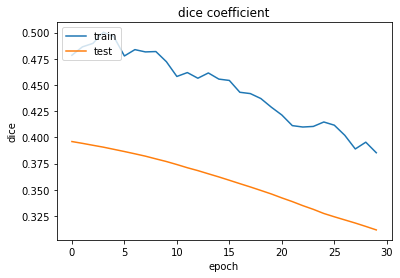

In [ ]:
plt.plot(history.history["dice_coef"])
plt.plot(history.history["val_dice_coef"])
plt.title("dice coefficient")
plt.ylabel("dice")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

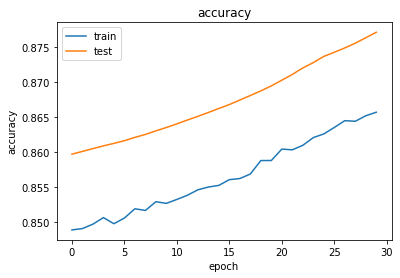

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()